##### Loading the boston housing dataset

In [1]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

In [4]:
train_targets[0:20]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5])

#### Normalizing the data

In [5]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

#### Model definition

In [6]:
from keras import models
from keras import layers
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

#### K-fold validation

In [7]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    #Prepares the validation data: data from partition #k 
    val_data = train_data[i * num_val_samples:(i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples:(i + 1) * num_val_samples]
    
    #Prepares the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    #Builds the Keras model (already compiled)
    model = build_model()
    #Trains the model (in silent mode, verbose = 0)
    model.fit(partial_train_data, partial_train_targets,
                epochs=num_epochs, batch_size=1, verbose=0)
    #Evaluates the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

W0923 12:43:54.288932 4664554944 deprecation_wrapper.py:119] From /anaconda3/envs/keras-tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0923 12:43:54.324493 4664554944 deprecation_wrapper.py:119] From /anaconda3/envs/keras-tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0923 12:43:54.334663 4664554944 deprecation_wrapper.py:119] From /anaconda3/envs/keras-tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0923 12:43:54.379133 4664554944 deprecation_wrapper.py:119] From /anaconda3/envs/keras-tensorflow/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimize

processing fold # 0


W0923 12:43:54.588739 4664554944 deprecation_wrapper.py:119] From /anaconda3/envs/keras-tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0923 12:43:54.595668 4664554944 deprecation_wrapper.py:119] From /anaconda3/envs/keras-tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



processing fold # 1
processing fold # 2
processing fold # 3


In [8]:
all_scores

[2.067351315281179, 2.234305230697783, 2.8512333147596607, 2.3825703611468323]

In [9]:
np.mean(all_scores)

2.3838650554713636

#### Saving the validation logs at each fold

In [10]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    #Prepares the validation data: data from partition #k 
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]   
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples] 
    
    #Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)

    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    #Builds the Keras model (already compiled)
    model = build_model()
    #Trains the model (in silent mode, verbose = 0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


#### Building the history of successive mean K-fold validation scores

In [11]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

#### Plotting validation scores

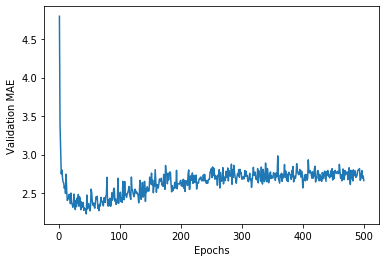

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

#### Plotting validation scores, excluding the first 10 data points

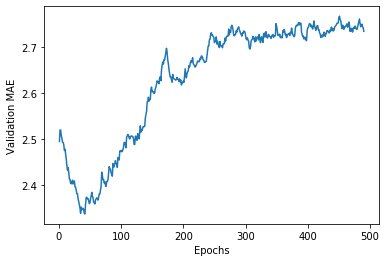

In [15]:
def smooth_curve(points, factor=0.9):

    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()